## Code to mask a GeoTIFF with a shapefile.

- Shapefiles are vector-based regional boundaries for a region. They require GeoPandas library, which is similar to Pandas.
- A "masked" GeoTIFF only contains data within that region.
- *NOTE: GeoPandas and Rasterio are not compatibile in the most recent version of Python.*

***This code requires an environment that uses Python 3.9***


Read the shapefile and select the administrative boundary.

In [39]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import numpy as np
import matplotlib.pyplot as plt

# Load the shapefile
# Zimbabwe Boundaries - national (adm0). (Humdata, 2023)
# Source: https://data.humdata.org/dataset/cod-ab-zwe
admin = gpd.read_file("zwe_admbnda_adm0_zimstat_ocha_20180911.shp")

# Print the first five rows of the attribute table
admin.head()


,Shape_Leng,Shape_Area,ADM0_EN,ADM0_PCODE,ADM0_REF,ADM0ALT1EN,ADM0ALT2EN,date,validOn,validTo,geometry
0,29.959574,33.540878,Zimbabwe,ZW,None,None,None,2018-08-31,2018-09-11,None,"POLYGON ((29.83081 -15.60714, 29.83090 -15.607..."


Read the GeoTIFF file and check the metadata.

In [33]:
# Check the metadata of the GeoTIFF file
with rasterio.open("wc2.1_2.5m_tmin_1960-01.tif") as src:
    # Access metadata using .profile
    profile = src.profile
    print("\nMetadata using .profile:")
    print(profile)



Metadata using .profile:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 8640, 'height': 4320, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.041666666666666664, 0.0, -180.0,
       0.0, -0.041666666666666664, 90.0), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}


In [34]:
# Display the relevant values
with rasterio.open("wc2.1_2.5m_tmin_1960-01.tif") as src:
    print(f"Nodata value is set to: {src.nodata}")
    print(f"Width: {src.width}")
    print(f"Height: {src.height}")
    print(f"Number of bands: {src.count}")
    print(f"Coordinate Reference System (CRS): {src.crs}")
    print(f"Affine Transform: \n{src.transform}")
    print(f"Data type: {src.dtypes}")
    print(f"Bounding box: {src.bounds}")
    print(f"No data value: {src.nodatavals}")
    print(f"Scale: {src.scales}")
    print(f"Offset: {src.offsets}")

Nodata value is set to: nan
Width: 8640
Height: 4320
Number of bands: 1
Coordinate Reference System (CRS): EPSG:4326
Affine Transform: 
| 0.04, 0.00,-180.00|
| 0.00,-0.04, 90.00|
| 0.00, 0.00, 1.00|
Data type: ('float32',)
Bounding box: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0)
No data value: (nan,)
Scale: (1.0,)
Offset: (0.0,)


Mask the GeoTiff data to only display data in the desired region.

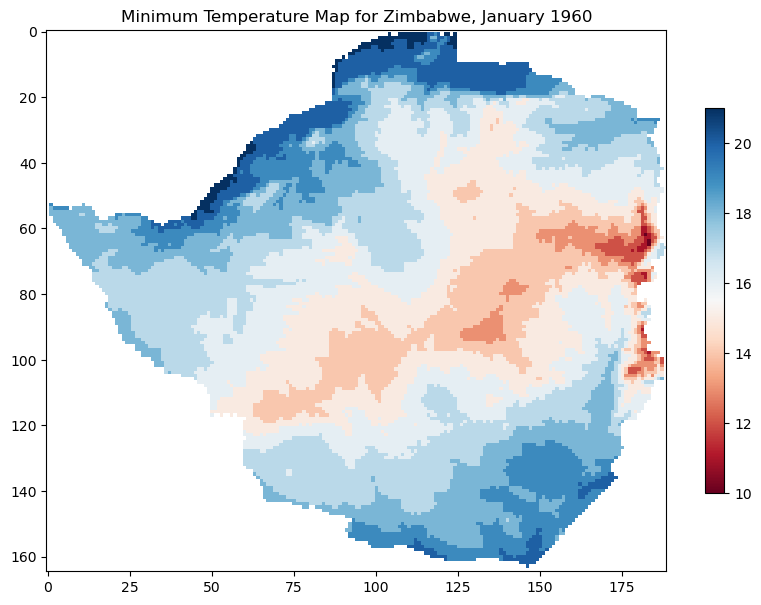

In [38]:
# Define the region
region = admin[admin['ADM0_EN'] == 'Zimbabwe']

# Open the GeoTIFF file
with rasterio.open("wc2.1_2.5m_tmin_1960-01.tif") as src:
    # Convert the region's geometry to GeoJSON format
    geojson = [region.geometry.to_crs(src.crs).iloc[0].__geo_interface__]
    
    # Mask the GeoTIFF with the district polygon
    out_image, out_transform = mask(src, geojson, crop=True)
    # out_image now contains the climate data for only the specified the region

    # Plot
    fig, ax = plt.subplots(figsize=(10, 10))
    # Display the image
    # Note: out_image is a 3-dimensional array (1, height, width), so we use [0] to select the 2D data array.
    img = ax.imshow(out_image[0], cmap='RdBu')
    ax.set_title("Minimum Temperature Map for Zimbabwe, January 1960")
    # Optionally, add a color bar
    fig.colorbar(img, ax=ax, shrink=0.5, aspect=20)
    plt.show()

In [37]:
# Calculate the average, ignoring nan values if necessary
average_value = np.nanmean(out_image)
print("Average Value:", average_value)

Average Value: 16.548716
